In [1]:
import math
import numpy as np
import pandas as pd
import os
import random
import re
import spacy
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_
from torch.autograd import Variable

from glob import glob
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook
from torchtext.data import Field, BucketIterator, TabularDataset

## Load data

In [2]:
glob('../data/news-summary-kaggle/*')

['../data/news-summary-kaggle/news_test.csv',
 '../data/news-summary-kaggle/news_train.csv',
 '../data/news-summary-kaggle/news_summary_more.csv',
 '../data/news-summary-kaggle/news-cleaned.csv',
 '../data/news-summary-kaggle/news-splitted.csv',
 '../data/news-summary-kaggle/news_summary.csv',
 '../data/news-summary-kaggle/news_val.csv']

In [3]:
data = pd.read_csv('../data/news-summary-kaggle/news_summary.csv', encoding='iso-8859-2')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4514 entries, 0 to 4513
Data columns (total 6 columns):
author       4514 non-null object
date         4514 non-null object
headlines    4514 non-null object
read_more    4514 non-null object
text         4514 non-null object
ctext        4396 non-null object
dtypes: object(6)
memory usage: 211.7+ KB


In [5]:
data.head()

,author,date,headlines,read_more,text,ctext
0,Chhavi Tyagi,"03 Aug 2017,Thursday",Daman & Diu revokes mandatory Rakshabandhan in...,http://www.hindustantimes.com/india-news/raksh...,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Daisy Mowke,"03 Aug 2017,Thursday",Malaika slams user who trolled her for 'divorc...,http://www.hindustantimes.com/bollywood/malaik...,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,Arshiya Chopra,"03 Aug 2017,Thursday",'Virgin' now corrected to 'Unmarried' in IGIMS...,http://www.hindustantimes.com/patna/bihar-igim...,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Sumedha Sehra,"03 Aug 2017,Thursday",Aaj aapne pakad liya: LeT man Dujana before be...,http://indiatoday.intoday.in/story/abu-dujana-...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Aarushi Maheshwari,"03 Aug 2017,Thursday",Hotel staff to get training to spot signs of s...,http://indiatoday.intoday.in/story/sex-traffic...,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [6]:
data_more = pd.read_csv('../data/news-summary-kaggle/news_summary_more.csv', encoding='iso-8859-2')

In [7]:
data_more.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


## Merge and filter data

In [8]:
raw_data = pd.DataFrame({
    'text': pd.concat([data.text, data_more.text], ignore_index=True),
    'summary': pd.concat([data.headlines, data_more.headlines], ignore_index=True)
})

In [9]:
raw_data.head()

,text,summary
0,The Administration of Union Territory Daman an...,Daman & Diu revokes mandatory Rakshabandhan in...
1,Malaika Arora slammed an Instagram user who tr...,Malaika slams user who trolled her for 'divorc...
2,The Indira Gandhi Institute of Medical Science...,'Virgin' now corrected to 'Unmarried' in IGIMS...
3,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Aaj aapne pakad liya: LeT man Dujana before be...
4,Hotels in Maharashtra will train their staff t...,Hotel staff to get training to spot signs of s...


In [10]:
raw_data['text_len'] = raw_data.text.apply(lambda x: len(x))
raw_data['summary_len'] = raw_data.summary.apply(lambda x: len(x))

In [11]:
raw_data.text_len.hist(bins=50)

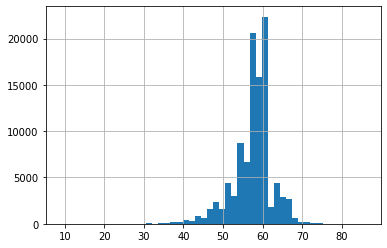

In [12]:
raw_data.summary_len.hist(bins=50)

### Remove shortest summaries

In [13]:
raw_data = raw_data[raw_data.summary_len > raw_data.summary_len.quantile(.01)]

In [14]:
nlp = spacy.load('en', disable=['ner', 'parser'])

In [17]:
def spacy_strip(row):
    row=re.sub("(\\t)", ' ', str(row))
    row=re.sub("(\\r)", ' ', str(row))
    row=re.sub("(\\n)", ' ', str(row))

    row=re.sub("(__+)", ' ', str(row))
    row=re.sub("(-+)", ' ', str(row))
    row=re.sub("(~~+)", ' ', str(row))
    row=re.sub("(\+\++)", ' ', str(row))
    row=re.sub("(\.\.+)", ' ', str(row))

    row=re.sub("(\.\s+)", ' ', str(row))
    row=re.sub("(\-\s+)", ' ', str(row))
    row=re.sub("(\:\s+)", ' ', str(row))

    row=re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", '', str(row))

    parsed = nlp(row)
    lemmatized = ''
    for sentence in parsed:
        lemmatized += sentence.lemma_.strip() + ' '
    return lemmatized.lstrip().rstrip()

In [18]:
raw_data['text_stripped'] = [
    spacy_strip(row) for row in tqdm_notebook(raw_data.text)
]

In [19]:
raw_data['summary_stripped'] = [
    spacy_strip(row) for row in tqdm_notebook(raw_data.summary)
]

In [ ]:
# raw_data.to_csv('../data/news-summary-kaggle/news-cleaned.csv')

## Separate to train, val and test

In [2]:
# data = pd.read_csv('../data/news-summary-kaggle/news-cleaned.csv', index_col=0)

In [3]:
data.reset_index(drop=True, inplace=True)

In [4]:
data.head()

,text,summary,text_len,summary_len,text_stripped,summary_stripped
0,The Administration of Union Territory Daman an...,Daman & Diu revokes mandatory Rakshabandhan in...,358,60,the Administration of Union Territory Daman an...,Daman Diu revoke mandatory Rakshabandhan in o...
1,Malaika Arora slammed an Instagram user who tr...,Malaika slams user who trolled her for 'divorc...,361,60,Malaika Arora slam an Instagram user who troll...,Malaika slam user who troll -PRON- for divorce...
2,The Indira Gandhi Institute of Medical Science...,'Virgin' now corrected to 'Unmarried' in IGIMS...,398,52,the Indira Gandhi Institute of Medical Science...,Virgin now correct to Unmarried in IGIMS form
3,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Aaj aapne pakad liya: LeT man Dujana before be...,368,56,Lashkar e Taibas Kashmir commander Abu Dujana ...,Aaj aapne pakad liya LeT man Dujana before be ...
4,Hotels in Maharashtra will train their staff t...,Hotel staff to get training to spot signs of s...,366,60,hotel in Maharashtra will train -PRON- staff t...,hotel staff to get training to spot sign of se...


In [5]:
def train_val_test_split(df, train_percentage=0.8, val_percentage=0.1, seed=None, inplace=False):
    np.random.seed(seed)
    permutation = np.random.permutation(df.index)
    length = len(df.index)
    train_end = int(train_percentage * length)
    val_end = int(val_percentage * length) + train_end
    train_ids = permutation[:train_end]
    val_ids = permutation[train_end:val_end]
    test_ids = permutation[val_end:]
    if inplace:
        df.loc[df.index.isin(train_ids), 'dataset'] = ['train'] * len(train_ids)
        df.loc[df.index.isin(val_ids), 'dataset'] = ['val'] * len(val_ids)
        df.loc[df.index.isin(test_ids), 'dataset'] = ['test'] * len(test_ids)
        return df
    else:
        train = df.iloc[train_ids]
        val = df.iloc[val_ids]
        test = df.iloc[test_ids]
        return train.reset_index(drop=True), val.reset_index(drop=True), test.reset_index(drop=True)

In [6]:
train_data, val_data, test_data = train_val_test_split(data, seed=9, inplace=False)

### Save data as separate datasets:
* train
* val
* test

In [7]:
# train_data[['text_stripped', 'summary_stripped']].to_csv('../data/news-summary-kaggle/news_train.csv', index=False)
# val_data[['text_stripped', 'summary_stripped']].to_csv('../data/news-summary-kaggle/news_val.csv', index=False)
# test_data[['text_stripped', 'summary_stripped']].to_csv('../data/news-summary-kaggle/news_test.csv', index=False)

In [20]:
def tokenize_en(text):
    text=re.sub("(\\t)", ' ', str(text))
    text=re.sub("(\\r)", ' ', str(text))
    text=re.sub("(\\n)", ' ', str(text))

    text=re.sub("(__+)", ' ', str(text))
    text=re.sub("(-+)", ' ', str(text))
    text=re.sub("(~~+)", ' ', str(text))
    text=re.sub("(\+\++)", ' ', str(text))
    text=re.sub("(\.\.+)", ' ', str(text))

    text=re.sub("(\.\s+)", ' ', str(text))
    text=re.sub("(\-\s+)", ' ', str(text))
    text=re.sub("(\:\s+)", ' ', str(text))

    text=re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", '', str(text))
    return [tok.text for tok in nlp.tokenizer(text)]

## Get dataset

In [23]:
def load_dataset(batch_size):
    TEXT = Field(tokenize=tokenize_en, include_lengths=True,
                 init_token='<sos>', eos_token='<eos>')
    SUMMARY = Field(tokenize=tokenize_en, include_lengths=True,
                    init_token='<sos>', eos_token='<eos>')
    train, val, test = TabularDataset.splits(
        skip_header=True, 
        path='../data/news-summary-kaggle/', format='csv', 
        fields=[('text', TEXT), ('summary', SUMMARY)],
        train='news_train.csv', validation='news_val.csv', test='news_test.csv'
    )
    TEXT.build_vocab(train, min_freq=2)
    SUMMARY.build_vocab(train, min_freq=2)
    train_iter, val_iter, test_iter = BucketIterator.splits(
        (train, val, test), batch_size=batch_size, repeat=False,
    )
    return train_iter, val_iter, test_iter, TEXT, SUMMARY

In [25]:
batch_size = 64

In [26]:
train_iter, val_iter, test_iter, TEXT, SUMMARY = load_dataset(batch_size)

In [27]:
def indices_from_text(text, lang=TEXT):
    indices = []
    for word in text.strip().split(' '):
        indices.append(lang.vocab.stoi[word])
    return indices

In [28]:
def text_from_indices(indices, lang=TEXT):
    text = ""
    for element in indices:
        if type(element) is torch.Tensor:
            text += lang.vocab.itos[element.item()] + " "
        else:
            text += lang.vocab.itos[element] + " "
    return text

#### Random text

In [43]:
text_from_indices(next(iter(train_iter)).text[0].transpose(0, 1)[0])

'<sos> Karnataka Chief Minister Siddaramaiah on Tuesday tweet that   PRON   be glad PM Narendra Modi be talk about corruption and that   PRON   now invite   PRON   to walk the Talk Siddaramaiah ask pm Modi to appoint Lok Pal investigate Justice <unk> death investigate the astronomical rise of Jay Shah and appoint an <unk> person as bjp CM candidate <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> '

#### Random summary

In [44]:
text_from_indices(next(iter(train_iter)).summary[0].transpose(0, 1)[0])

'<sos> easy soul   be   taxiway comet court in until   be   of while <eos> '

## Seq2Seq model

In [45]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, n_layers=1, dropout=0.1):
        super(EncoderRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.gru = nn.GRU(embedding_size, hidden_size, n_layers,
                          dropout=dropout, bidirectional=True)

    def forward(self, sequence, hidden=None):
        embedding_output = self.embedding(sequence) # max_text_len x batch_size x embedding_size
        encoder_outputs, hidden = self.gru(embedding_output, hidden)
        # hidden: bidirectional x batch_size x hidden_size
        # output: max_text_len x batch_size x bidirectional * hidden_size
        encoder_outputs = encoder_outputs[:, :, :self.hidden_size] + encoder_outputs[:, :, self.hidden_size:]
        # output: max_text_len x batch_size x hidden_size
        return encoder_outputs, hidden

In [57]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.hidden_size = hidden_size
        self.attention = nn.Linear(hidden_size * 2, hidden_size)
        self.v = nn.Parameter(torch.rand(hidden_size))
        stdv = 1. / math.sqrt(self.v.size(0))
        self.v.data.uniform_(-stdv, stdv)

    def forward(self, hidden, encoder_outputs):
        timestep = encoder_outputs.size(0)
        h = hidden.repeat(timestep, 1, 1).transpose(0, 1)
        encoder_outputs = encoder_outputs.transpose(0, 1) 
        attn_energies = self.score(h, encoder_outputs) # batch_size x t x hidden
        return F.softmax(attn_energies, dim=1).unsqueeze(1) # batch_size x t

    def score(self, hidden, encoder_outputs):
        # batch_size x t x 2*hidden -> batch_size x t x hidden
        energy = F.tanh(self.attention(torch.cat([hidden, encoder_outputs], 2)))
        energy = energy.transpose(1, 2) # batch_size x t x 2*hidden -> batch_size x t x hidden
        v = self.v.repeat(encoder_outputs.size(0), 1).unsqueeze(1) # batch_size x 1 x hidden
        energy = torch.bmm(v, energy) # batch_size x 1 x t
        return energy.squeeze(1) # batch_size x t

In [47]:
class DecoderRNN(nn.Module):
    def __init__(self, embedding_size, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(DecoderRNN, self).__init__()
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

        self.embedding = nn.Embedding(output_size, embedding_size)
        self.dropout = nn.Dropout(dropout, inplace=True)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(hidden_size + embedding_size, hidden_size, n_layers, dropout=dropout)
        self.output = nn.Linear(hidden_size * 2, output_size)

    def forward(self, sequence, hidden, encoder_outputs):
        # Get the embedding of the current input word (last output word)
        embedding_output = self.embedding(sequence).unsqueeze(0)  # 1 x batch_size x n
        embedding_output = self.dropout(embedding_output)
        # Calculate attention weights and apply to encoder outputs
        attention_weights = self.attention(hidden[-1], encoder_outputs)
        context = attention_weights.bmm(encoder_outputs.transpose(0, 1)) # batch_size x 1 x n
        context = context.transpose(0, 1)  # (1,B,N)
        # Combine embedded input word and attended context, run through RNN
        decoder_input = torch.cat([embedding_output, context], 2)
        decoder_output, hidden = self.gru(decoder_input, hidden)
        decoder_output = decoder_output.squeeze(0)  # (1,B,N) -> (B,N)
        context = context.squeeze(0)
        decoder_output = self.output(torch.cat([decoder_output, context], 1))
        decoder_output = F.log_softmax(decoder_output, dim=1)
        return decoder_output, hidden, attention_weights

In [48]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, text, summary, teacher_forcing_ratio=0.5):
        batch_size = text.size(1)
        max_len = summary.size(0)
        vocab_size = self.decoder.output_size

        encoder_output, hidden = self.encoder(text)
        hidden = hidden[:self.decoder.n_layers]
        output = Variable(summary.data[0, :])  # sos
        
        outputs = Variable(torch.zeros(max_len, batch_size, vocab_size))
        for t in range(1, max_len):
            output, hidden, attention_weights = self.decoder(
                    output, hidden, encoder_output)
            outputs[t] = output
            is_teacher = random.random() < teacher_forcing_ratio
            top_first = output.data.max(1)[1]
            output = Variable(summary.data[t] if is_teacher else top_first)
        return outputs

## Train

In [49]:
def train(e, model, optimizer, train_iter, vocab_size, grad_clip, lang=TEXT):
    model.train()
    total_loss = 0
    pad = lang.vocab.stoi['<pad>']
    for b, batch in tqdm_notebook(enumerate(train_iter), total=len(train_iter)):
        text, len_text = batch.text
        summary, len_summary = batch.summary
        optimizer.zero_grad()
        output = model(text, summary)
        loss = F.nll_loss(
            output[1:].view(-1, vocab_size),
            summary[1:].contiguous().view(-1),
            ignore_index=pad,
        )
        loss.backward()
        clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()
        total_loss += loss.data

        if b % 1 == 0 and b != 0:
            total_loss = total_loss / 100
            print(f'[{b}] [loss: {total_loss}] [loss_exp: {math.exp(total_loss)}]')
            total_loss = 0

In [50]:
def evaluate(model, val_iter, vocab_size, lang=TEXT):
    model.eval()
    pad = lang.vocab.stoi['<pad>']
    total_loss = 0
    for b, batch in enumerate(val_iter):
        text, len_text = batch.text
        summary, len_summary = batch.summary
        text = Variable(text.data, volatile=True)
        summary = Variable(summary.data, volatile=True)
        output = model(text, summary, teacher_forcing_ratio=0.0)
        loss = F.nll_loss(
            output[1:].view(-1, vocab_size),
            summary[1:].contiguous().view(-1),
            ignore_index=pad,
        )
        total_loss += loss.data
    return total_loss / len(val_iter)

In [51]:
epochs = 100
batch_size = 64
lr = 0.0001
grad_clip = 10.0

In [52]:
hidden_size = 256
embed_size = 128

In [53]:
print("[!] preparing dataset...")
text_size, summary_size = len(TEXT.vocab), len(SUMMARY.vocab)
print("[TRAIN]:%d (dataset:%d)\t[TEST]:%d (dataset:%d)"
      % (len(train_iter), len(train_iter.dataset),
         len(test_iter), len(test_iter.dataset)))
print("[TEXT_vocab]:%d [SUMMARY_vocab]:%d" % (text_size, summary_size))

[!] preparing dataset...
[TRAIN]:1274 (dataset:81498)	[TEST]:160 (dataset:10188)
[TEXT_vocab]:50576 [SUMMARY_vocab]:20530


In [58]:
print("[!] Instantiating models...")
encoder = EncoderRNN(text_size, embed_size, hidden_size,
                  n_layers=2, dropout=0.5)
decoder = DecoderRNN(embed_size, hidden_size, text_size,
                  n_layers=1, dropout=0.5)
seq2seq = Seq2Seq(encoder, decoder)
optimizer = optim.Adam(seq2seq.parameters(), lr=lr)
print(seq2seq)

[!] Instantiating models...
Seq2Seq(
  (encoder): EncoderRNN(
    (embedding): Embedding(50576, 128)
    (gru): GRU(128, 256, num_layers=2, dropout=0.5, bidirectional=True)
  )
  (decoder): DecoderRNN(
    (embedding): Embedding(50576, 128)
    (dropout): Dropout(p=0.5, inplace=True)
    (attention): BahdanauAttention(
      (attention): Linear(in_features=512, out_features=256, bias=True)
    )
    (gru): GRU(384, 256, dropout=0.5)
    (output): Linear(in_features=512, out_features=50576, bias=True)
  )
)


In [59]:
best_val_loss = None
for e in range(1, epochs+1):
    train(e, seq2seq, optimizer, train_iter,
          text_size, grad_clip, TEXT)
    val_loss = evaluate(seq2seq, val_iter, text_size, TEXT)
    print("[Epoch:%d] val_loss:%5.3f | val_pp:%5.2fS"
          % (e, val_loss, math.exp(val_loss)))

    # Save the model if the validation loss is the best we've seen so far.
    if not best_val_loss or val_loss < best_val_loss:
        print("[!] saving model...")
        if not os.path.isdir(".save"):
            os.makedirs(".save")
        torch.save(seq2seq.state_dict(), './.save/seq2seq_%d.pt' % (e))
        best_val_loss = val_loss
test_loss = evaluate(seq2seq, test_iter, text_size, TEXT)
print("[TEST] loss:%5.2f" % test_loss)

/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  app.launch_new_instance()


[1] [loss: 0.21644702553749084] [loss_exp: 1.2416573074830861]
[2] [loss: 0.10794827342033386] [loss_exp: 1.113990120997383]
[3] [loss: 0.10785089433193207] [loss_exp: 1.11388164693655]
[4] [loss: 0.10776355862617493] [loss_exp: 1.1137843695447416]
[5] [loss: 0.10750753432512283] [loss_exp: 1.1134992501803065]


KeyboardInterrupt: 